In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

#set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
#mount google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

#update dir to match my folder dir in drive
base_dir = '/content/drive/MyDrive/refuge2'  
train_dir = os.path.join(base_dir, 'train')  # train folder
val_dir = os.path.join(base_dir, 'val')      # validation folder
test_dir = os.path.join(base_dir, 'test')    # test folder

#directories for the project outputs
augmented_dir = '/content/drive/MyDrive/Augmented_Data'
fold_models_dir = '/content/drive/MyDrive/fold_models'

# Create necessary directories if they don't exist
#if not os.path.exists(augmented_dir):
 #   os.makedirs(augmented_dir)
  #  print(f"Created directory: {augmented_dir}")

#if not os.path.exists(fold_models_dir):
 #   os.makedirs(fold_models_dir)
  #  print(f"Created directory: {fold_models_dir}")

model_path = '/content/drive/MyDrive/glaucoma_model.pt'

#directory structure print to confirm
print(f"Base directory: {base_dir}")
print(f"Train directory: {train_dir}")
print(f"Val directory: {val_dir}")
print(f"Test directory: {test_dir}")

In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if isinstance(image, np.ndarray):
            image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def load_images_from_folder(folder, label, target_size=(224, 224)):
    images = []
    labels = []
    filenames = []

    print(f"Loading images from {folder}...")

    for filename in tqdm(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)

                img_array = np.array(img) / 255.0

                images.append(img_array)
                labels.append(label)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    return np.array(images), np.array(labels), filenames

Loading training data...
Loading images from /content/drive/MyDrive/refuge2/train/images...


  0%|          | 0/400 [00:00<?, ?it/s]

Loading validation data...
Loading images from /content/drive/MyDrive/refuge2/val/images...


  0%|          | 0/400 [00:00<?, ?it/s]

Loading test data...
Loading images from /content/drive/MyDrive/refuge2/test/images...


  0%|          | 0/400 [00:00<?, ?it/s]

Loaded 40 glaucoma images and 760 normal images
Total dataset size: 800 images


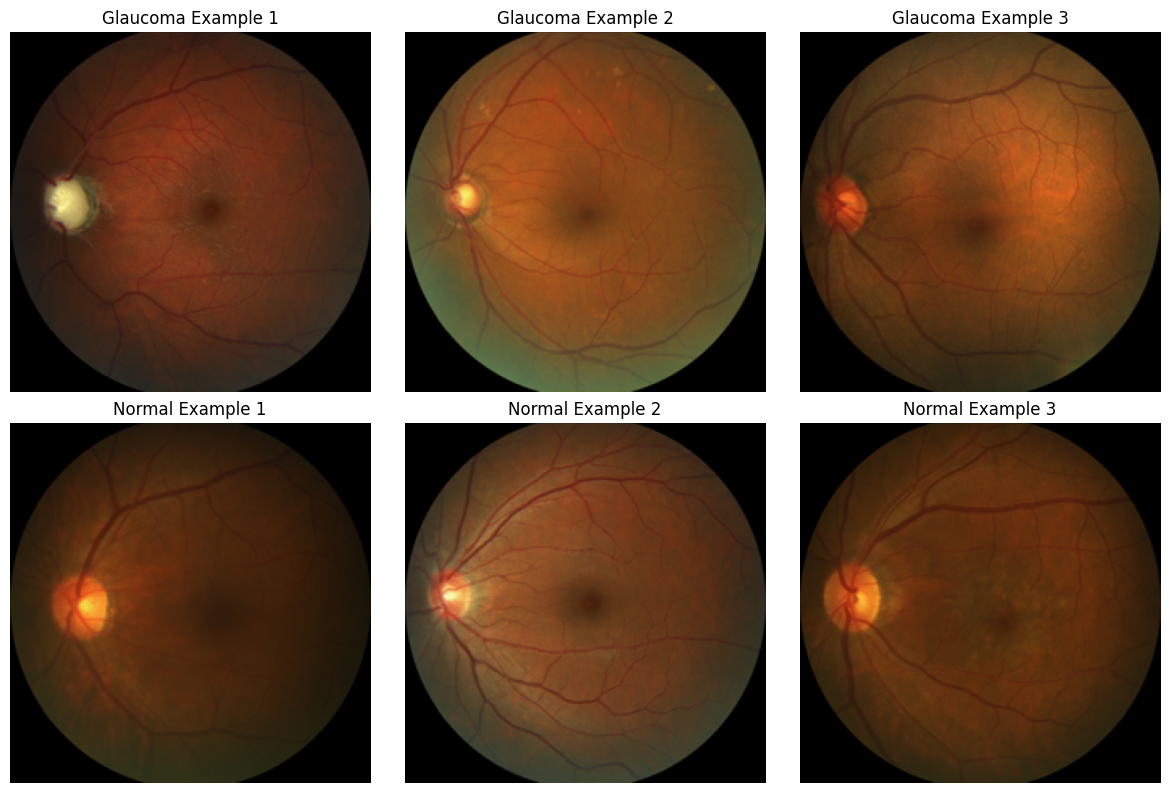

In [ ]:
# this cell

def is_glaucoma(image_path, masks_dir):
    filename = os.path.basename(image_path)

    if filename.startswith('g'):
        return True  # Glaucoma image
    elif filename.startswith('n'):
        return False  # Normal image

    mask_files = [f for f in os.listdir(masks_dir) if filename in f]
    if not mask_files:
        print(f"Warning: No mask found for {filename}. Assuming unlabeled or normal.")
        return False  

    mask_path = os.path.join(masks_dir, mask_files[0])
    mask = Image.open(mask_path)
    mask_array = np.array(mask)

    return np.max(mask_array) > 0 

def load_dataset_with_masks(data_dir):
    images_dir = os.path.join(data_dir, 'images')
    masks_dir = os.path.join(data_dir, 'mask')

    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        print(f"Warning: Could not find images or masks directory in {data_dir}")
        return [], [], []

    images = []
    labels = []
    filenames = []

    print(f"Loading images from {images_dir}...")

    for filename in tqdm(os.listdir(images_dir)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(images_dir, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))


                is_glaucoma_image = is_glaucoma(img_path, masks_dir)

                img_array = np.array(img) / 255.0

                images.append(img_array)
                labels.append(1 if is_glaucoma_image else 0)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    return np.array(images), np.array(labels), filenames


train_dir = '/content/drive/MyDrive/refuge2/train'
val_dir = '/content/drive/MyDrive/refuge2/val'

test_dir = '/content/drive/MyDrive/refuge2/test' 


print("Loading training data...")
X_train, y_train, train_filenames = load_dataset_with_masks(train_dir)

print("Loading validation data...")
X_val, y_val, val_filenames = load_dataset_with_masks(val_dir)

print("Loading test data...")
X_test, y_test, test_filenames = load_dataset_with_masks(test_dir)

#combine train and validation for full dataset
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
filenames = train_filenames + val_filenames

glaucoma_count = np.sum(y == 1)
normal_count = np.sum(y == 0)

print(f"Loaded {glaucoma_count} glaucoma images and {normal_count} normal images")
print(f"Total dataset size: {len(X)} images")
#display example
plt.figure(figsize=(12, 8))
for i in range(3):
    glaucoma_indices = np.where(y == 1)[0]
    if i < len(glaucoma_indices):
        plt.subplot(2, 3, i+1)
        plt.imshow(X[glaucoma_indices[i]])
        plt.title(f"Glaucoma Example {i+1}")
        plt.axis('off')

    normal_indices = np.where(y == 0)[0]
    if i < len(normal_indices):
        plt.subplot(2, 3, i+4)
        plt.imshow(X[normal_indices[i]])
        plt.title(f"Normal Example {i+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#number of images to generate
original_size = len(X)
augmented_size = int(original_size * 0.3)
print(f"Original dataset size: {original_size}")
print(f"Will generate {augmented_size} augmented images")

#data augmentation transforms
transform_augment = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

#augmented images and saving them
augmented_images = []
augmented_labels = []
augmentation_info = []

#balanced augmentation
glaucoma_indices = np.where(y == 1)[0]
normal_indices = np.where(y == 0)[0]

glaucoma_to_generate = int(augmented_size * (len(glaucoma_indices) / original_size))
normal_to_generate = augmented_size - glaucoma_to_generate

print(f"Generating {glaucoma_to_generate} glaucoma and {normal_to_generate} normal augmented images")

Original dataset size: 800
Will generate 240 augmented images
Generating 12 glaucoma and 228 normal augmented images


In [ ]:
def generate_augmented_images(indices, label_value, num_to_generate, prefix):
    count = 0
    for i in tqdm(range(num_to_generate)):
        idx = np.random.choice(indices)
        img = X[idx]

        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        aug_img = transform_augment(pil_img)
        aug_img_array = np.array(aug_img) / 255.0

        filename = f"{prefix}_aug_{count}.jpg"
        img_path = os.path.join(augmented_dir, filename)
        aug_img.save(img_path)

        augmented_images.append(aug_img_array)
        augmented_labels.append(label_value)

        augmentation_info.append({
            'filename': filename,
            'original_file': filenames[idx],
            'label': label_value,
            'label_name': 'Glaucoma' if label_value == 1 else 'Normal'
        })

        count += 1

Generating augmented glaucoma images...


  0%|          | 0/12 [00:00<?, ?it/s]

Generating augmented normal images...


  0%|          | 0/228 [00:00<?, ?it/s]

Generated 240 augmented images
Augmentation info saved to /content/drive/MyDrive/Augmented_Data/augmentation_info.csv
Final dataset size: 1040 images


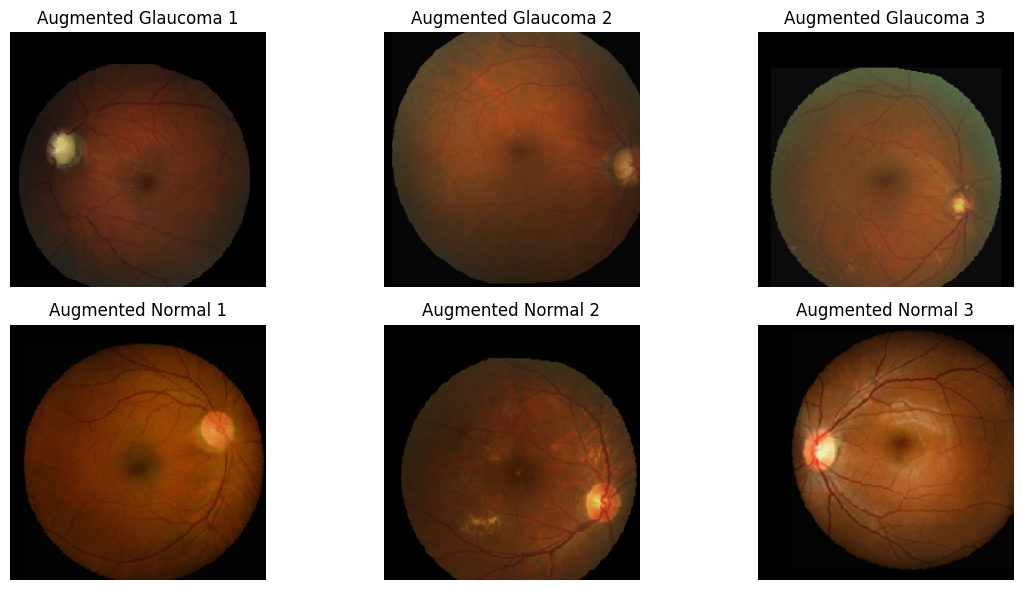

In [ ]:
print("Generating augmented glaucoma images...")
generate_augmented_images(glaucoma_indices, 1, glaucoma_to_generate, "glaucoma")

print("Generating augmented normal images...")
generate_augmented_images(normal_indices, 0, normal_to_generate, "normal")

#save augmentation info to CSV
augmentation_df = pd.DataFrame(augmentation_info)
augmentation_df.to_csv(os.path.join(augmented_dir, 'augmentation_info.csv'), index=False)
print(f"Generated {len(augmented_images)} augmented images")
print(f"Augmentation info saved to {os.path.join(augmented_dir, 'augmentation_info.csv')}")

X_augmented = np.array(augmented_images)
y_augmented = np.array(augmented_labels)

X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)

print(f"Final dataset size: {len(X_combined)} images")

plt.figure(figsize=(12, 6))
for i in range(3):
    g_idx = np.where(y_augmented == 1)[0][i]
    plt.subplot(2, 3, i+1)
    plt.imshow(X_augmented[g_idx])
    plt.title(f"Augmented Glaucoma {i+1}")
    plt.axis('off')
    n_idx = np.where(y_augmented == 0)[0][i]
    plt.subplot(2, 3, i+4)
    plt.imshow(X_augmented[n_idx])
    plt.title(f"Augmented Normal {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

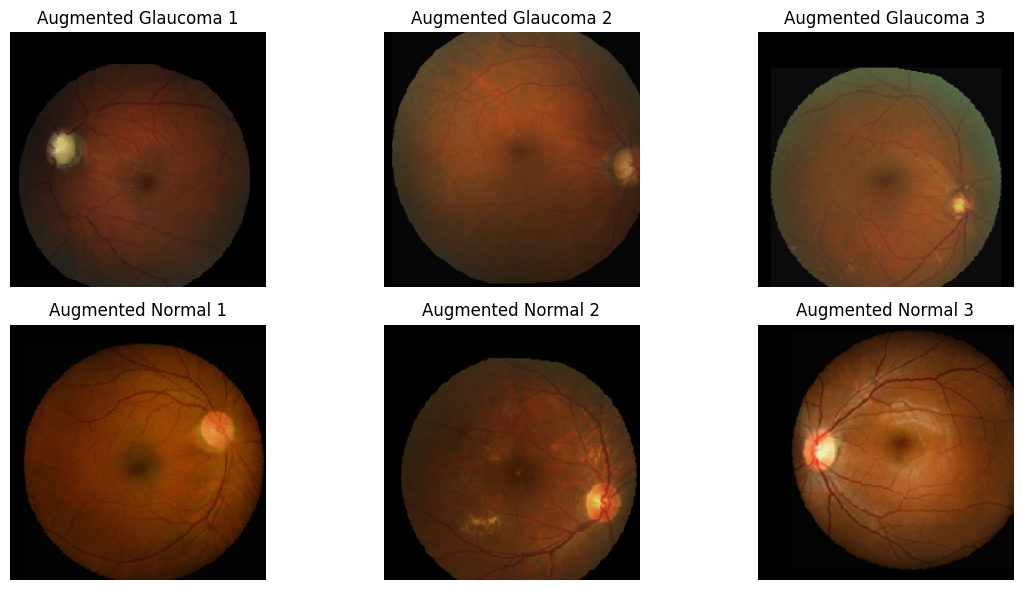

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(3):
    g_idx = np.where(y_augmented == 1)[0][i] 
    plt.subplot(2, 3, i+1)
    plt.imshow(X_augmented[g_idx])
    plt.title(f"Augmented Glaucoma {i+1}")
    plt.axis('off')

    n_indices = np.where(y_augmented == 0)[0]  #get normal indices
    if len(n_indices) > i:                    #check if enough normals
        n_idx = n_indices[i]                  #index safely
        plt.subplot(2, 3, i+4)
        plt.imshow(X_augmented[n_idx])
        plt.title(f"Augmented Normal {i+1}")
        plt.axis('off')
    else:
        print(f"Not enough augmented normal images to display example {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
class GlaucomaResNet(nn.Module):
    def __init__(self, pretrained=True):
        super(GlaucomaResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        in_features = self.resnet.fc.in_features


        self.resnet.fc = nn.Identity()  #remove the final layer
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

temp_model = GlaucomaResNet(pretrained=True)
print(temp_model)

GlaucomaResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    best_val_auc = 0.0
    best_model_state = None
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_loss = 0.0
        y_true = []
        y_scores = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy())
                y_scores.extend(outputs.cpu().numpy())

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        val_auc = auc(fpr, tpr)
        val_aucs.append(val_auc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            print(f"New best model with AUC: {best_val_auc:.4f}")

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, val_aucs

In [ ]:
#5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
fold_results = []

print("5-fold cross-validation>>>")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Training Fold 1
Training set: 832 images
Validation set: 208 images


Epoch 1/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.2439, Val Loss: 0.2065, Val AUC: 0.5676
New best model with AUC: 0.5676


Epoch 2/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1877, Val Loss: 0.1953, Val AUC: 0.7010
New best model with AUC: 0.7010


Epoch 3/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1786, Val Loss: 0.1835, Val AUC: 0.7877
New best model with AUC: 0.7877


Epoch 4/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1730, Val Loss: 0.1740, Val AUC: 0.8186
New best model with AUC: 0.8186


Epoch 5/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1695, Val Loss: 0.1757, Val AUC: 0.8062


Epoch 6/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1626, Val Loss: 0.1739, Val AUC: 0.8463
New best model with AUC: 0.8463


Epoch 7/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1515, Val Loss: 0.1623, Val AUC: 0.8514
New best model with AUC: 0.8514


Epoch 8/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1450, Val Loss: 0.1572, Val AUC: 0.8625
New best model with AUC: 0.8625


Epoch 9/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1501, Val Loss: 0.1565, Val AUC: 0.8634
New best model with AUC: 0.8634


Epoch 10/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1503, Val Loss: 0.1582, Val AUC: 0.8703
New best model with AUC: 0.8703


Epoch 11/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1469, Val Loss: 0.1490, Val AUC: 0.8805
New best model with AUC: 0.8805


Epoch 12/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1327, Val Loss: 0.1454, Val AUC: 0.8860
New best model with AUC: 0.8860


Epoch 13/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1341, Val Loss: 0.1530, Val AUC: 0.8989
New best model with AUC: 0.8989


Epoch 14/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1306, Val Loss: 0.1499, Val AUC: 0.8906


Epoch 15/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1168, Val Loss: 0.1424, Val AUC: 0.9045
New best model with AUC: 0.9045


Epoch 16/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1229, Val Loss: 0.1389, Val AUC: 0.8989


Epoch 17/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1128, Val Loss: 0.1366, Val AUC: 0.9026


Epoch 18/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1172, Val Loss: 0.1351, Val AUC: 0.9059
New best model with AUC: 0.9059


Epoch 19/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1074, Val Loss: 0.1404, Val AUC: 0.9054


Epoch 20/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1102, Val Loss: 0.1352, Val AUC: 0.9068
New best model with AUC: 0.9068


Epoch 21/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1054, Val Loss: 0.1418, Val AUC: 0.9063


Epoch 22/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1050, Val Loss: 0.1360, Val AUC: 0.9151
New best model with AUC: 0.9151


Epoch 23/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1133, Val Loss: 0.1371, Val AUC: 0.9086


Epoch 24/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0957, Val Loss: 0.1393, Val AUC: 0.9054


Epoch 25/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0924, Val Loss: 0.1257, Val AUC: 0.9202
New best model with AUC: 0.9202


Epoch 26/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0910, Val Loss: 0.1394, Val AUC: 0.9128


Epoch 27/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0915, Val Loss: 0.1434, Val AUC: 0.9202


Epoch 28/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0996, Val Loss: 0.1303, Val AUC: 0.9137


Epoch 29/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0907, Val Loss: 0.1329, Val AUC: 0.9220
New best model with AUC: 0.9220


Epoch 30/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0783, Val Loss: 0.1301, Val AUC: 0.9151
Saved model for fold 1 to /content/drive/MyDrive/fold_models/model_fold1.pt


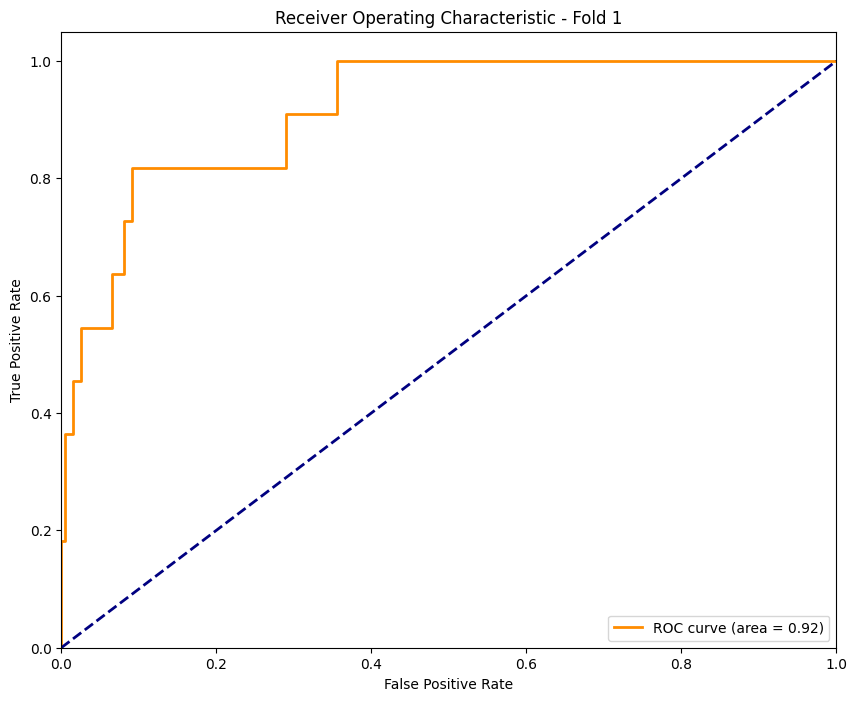

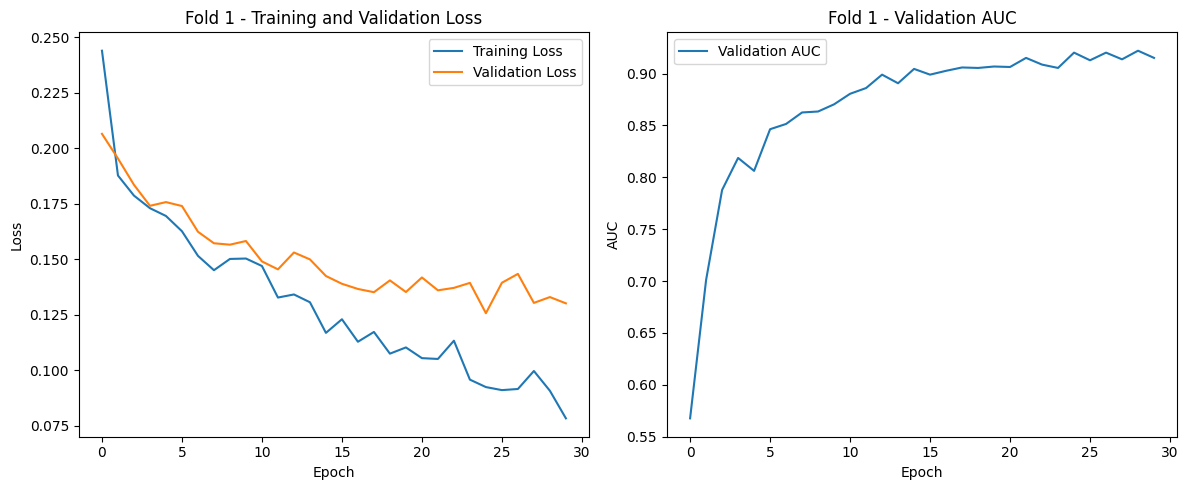


Training Fold 2
Training set: 832 images
Validation set: 208 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.2640, Val Loss: 0.1509, Val AUC: 0.4940
New best model with AUC: 0.4940


Epoch 2/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.2010, Val Loss: 0.1439, Val AUC: 0.7008
New best model with AUC: 0.7008


Epoch 3/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1997, Val Loss: 0.1377, Val AUC: 0.8102
New best model with AUC: 0.8102


Epoch 4/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1873, Val Loss: 0.1359, Val AUC: 0.8507
New best model with AUC: 0.8507


Epoch 5/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1739, Val Loss: 0.1238, Val AUC: 0.8550
New best model with AUC: 0.8550


Epoch 6/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1596, Val Loss: 0.1159, Val AUC: 0.8827
New best model with AUC: 0.8827


Epoch 7/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1649, Val Loss: 0.1143, Val AUC: 0.8934
New best model with AUC: 0.8934


Epoch 8/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1465, Val Loss: 0.1241, Val AUC: 0.9126
New best model with AUC: 0.9126


Epoch 9/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1558, Val Loss: 0.1119, Val AUC: 0.9097


Epoch 10/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1465, Val Loss: 0.1120, Val AUC: 0.9041


Epoch 11/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1451, Val Loss: 0.1056, Val AUC: 0.9097


Epoch 12/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1370, Val Loss: 0.1012, Val AUC: 0.9140
New best model with AUC: 0.9140


Epoch 13/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1376, Val Loss: 0.1084, Val AUC: 0.9240
New best model with AUC: 0.9240


Epoch 14/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1341, Val Loss: 0.0962, Val AUC: 0.9275
New best model with AUC: 0.9275


Epoch 15/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1289, Val Loss: 0.1089, Val AUC: 0.9339
New best model with AUC: 0.9339


Epoch 16/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1233, Val Loss: 0.0971, Val AUC: 0.9296


Epoch 17/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1195, Val Loss: 0.0992, Val AUC: 0.9303


Epoch 18/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1144, Val Loss: 0.0904, Val AUC: 0.9360
New best model with AUC: 0.9360


Epoch 19/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1148, Val Loss: 0.0894, Val AUC: 0.9389
New best model with AUC: 0.9389


Epoch 20/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1242, Val Loss: 0.0886, Val AUC: 0.9396
New best model with AUC: 0.9396


Epoch 21/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1171, Val Loss: 0.0876, Val AUC: 0.9431
New best model with AUC: 0.9431


Epoch 22/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1233, Val Loss: 0.0896, Val AUC: 0.9502
New best model with AUC: 0.9502


Epoch 23/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1008, Val Loss: 0.0815, Val AUC: 0.9524
New best model with AUC: 0.9524


Epoch 24/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1123, Val Loss: 0.0838, Val AUC: 0.9517


Epoch 25/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1035, Val Loss: 0.0853, Val AUC: 0.9531
New best model with AUC: 0.9531


Epoch 26/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1086, Val Loss: 0.0843, Val AUC: 0.9495


Epoch 27/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1056, Val Loss: 0.0835, Val AUC: 0.9524


Epoch 28/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0970, Val Loss: 0.0806, Val AUC: 0.9566
New best model with AUC: 0.9566


Epoch 29/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.1138, Val Loss: 0.0850, Val AUC: 0.9467


Epoch 30/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0894, Val Loss: 0.0838, Val AUC: 0.9524
Saved model for fold 2 to /content/drive/MyDrive/fold_models/model_fold2.pt


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


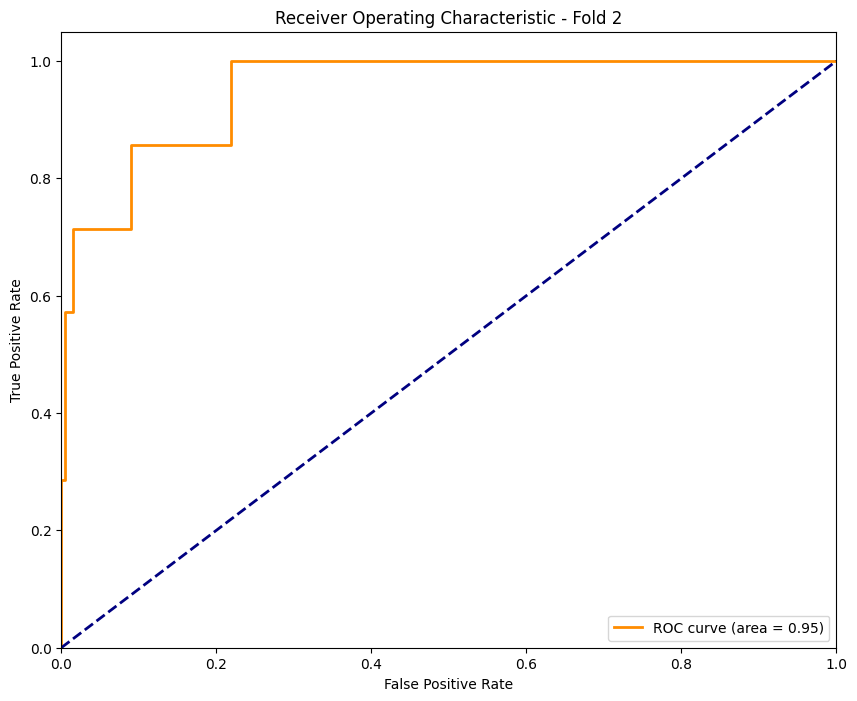

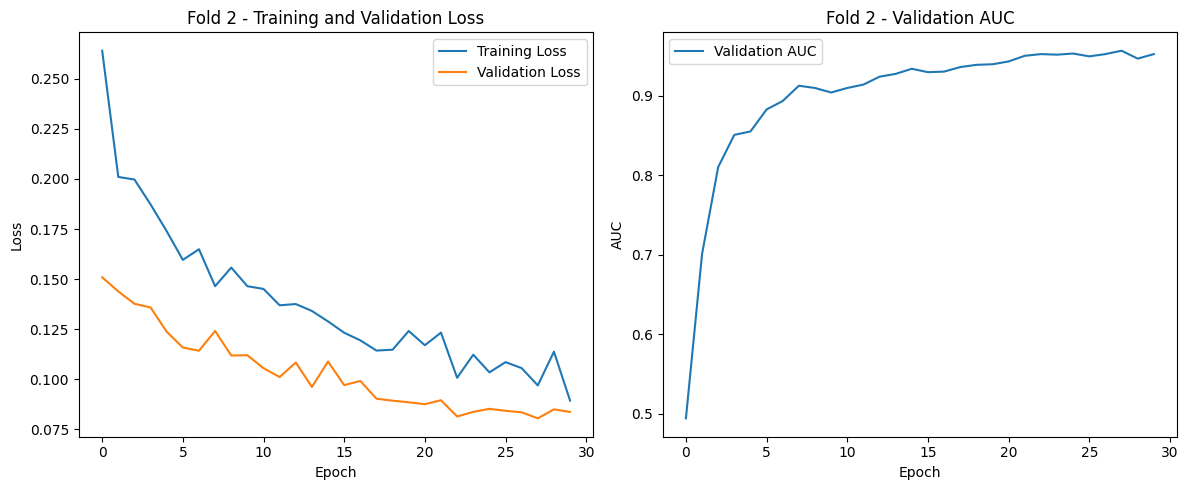


Training Fold 3
Training set: 832 images
Validation set: 208 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.2481, Val Loss: 0.2118, Val AUC: 0.7177
New best model with AUC: 0.7177


Epoch 2/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.2009, Val Loss: 0.2033, Val AUC: 0.8214
New best model with AUC: 0.8214


Epoch 3/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1795, Val Loss: 0.1922, Val AUC: 0.8767
New best model with AUC: 0.8767


Epoch 4/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1748, Val Loss: 0.1852, Val AUC: 0.8975
New best model with AUC: 0.8975


Epoch 5/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1629, Val Loss: 0.1748, Val AUC: 0.8997
New best model with AUC: 0.8997


Epoch 6/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1637, Val Loss: 0.1701, Val AUC: 0.9014
New best model with AUC: 0.9014


Epoch 7/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1552, Val Loss: 0.1738, Val AUC: 0.9039
New best model with AUC: 0.9039


Epoch 8/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1445, Val Loss: 0.1604, Val AUC: 0.9145
New best model with AUC: 0.9145


Epoch 9/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1387, Val Loss: 0.1625, Val AUC: 0.9188
New best model with AUC: 0.9188


Epoch 10/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1375, Val Loss: 0.1555, Val AUC: 0.9184


Epoch 11/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1321, Val Loss: 0.1553, Val AUC: 0.9103


Epoch 12/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1252, Val Loss: 0.1486, Val AUC: 0.9222
New best model with AUC: 0.9222


Epoch 13/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1184, Val Loss: 0.1449, Val AUC: 0.9141


Epoch 14/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1225, Val Loss: 0.1549, Val AUC: 0.9137


Epoch 15/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1139, Val Loss: 0.1667, Val AUC: 0.9222


Epoch 16/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1199, Val Loss: 0.1523, Val AUC: 0.9188


Epoch 17/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1186, Val Loss: 0.1542, Val AUC: 0.9235
New best model with AUC: 0.9235


Epoch 18/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1106, Val Loss: 0.1489, Val AUC: 0.9213


Epoch 19/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1000, Val Loss: 0.1481, Val AUC: 0.9230


Epoch 20/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1021, Val Loss: 0.1362, Val AUC: 0.9230


Epoch 21/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0873, Val Loss: 0.1438, Val AUC: 0.9192


Epoch 22/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1123, Val Loss: 0.1595, Val AUC: 0.9218


Epoch 23/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0883, Val Loss: 0.1628, Val AUC: 0.9171


Epoch 24/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1014, Val Loss: 0.1393, Val AUC: 0.9184


Epoch 25/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0954, Val Loss: 0.1420, Val AUC: 0.9222


Epoch 26/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0944, Val Loss: 0.1371, Val AUC: 0.9256
New best model with AUC: 0.9256


Epoch 27/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0789, Val Loss: 0.1741, Val AUC: 0.9269
New best model with AUC: 0.9269


Epoch 28/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0855, Val Loss: 0.1384, Val AUC: 0.9209


Epoch 29/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0677, Val Loss: 0.1408, Val AUC: 0.9141


Epoch 30/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0943, Val Loss: 0.1880, Val AUC: 0.9154
Saved model for fold 3 to /content/drive/MyDrive/fold_models/model_fold3.pt


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


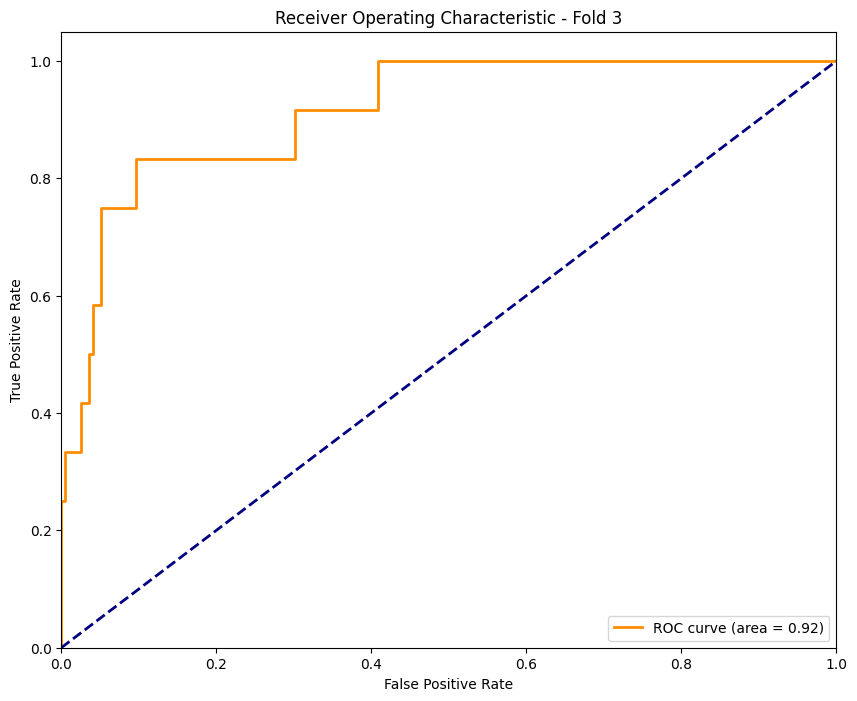

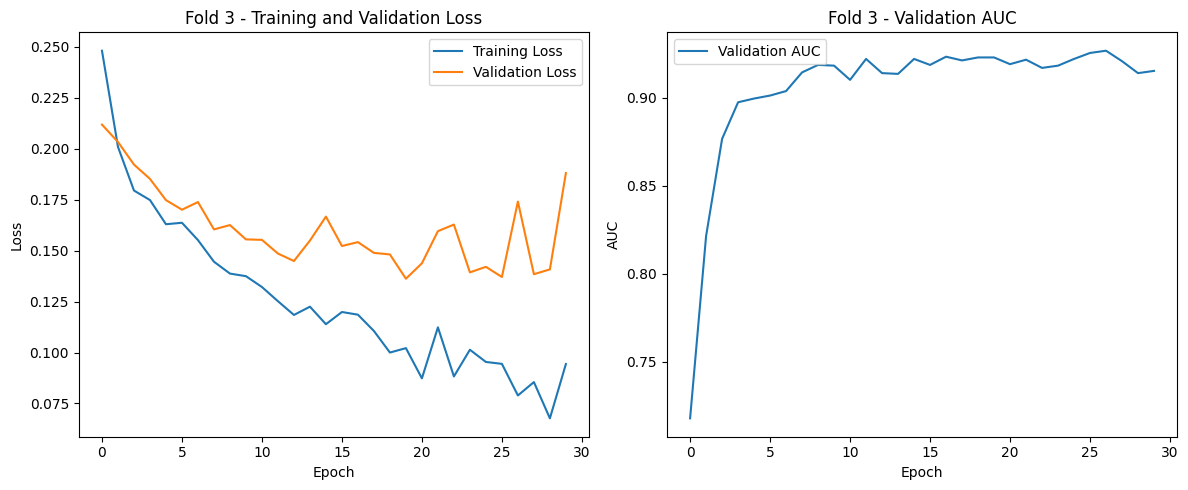


Training Fold 4
Training set: 832 images
Validation set: 208 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.2674, Val Loss: 0.1978, Val AUC: 0.4914
New best model with AUC: 0.4914


Epoch 2/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1991, Val Loss: 0.1907, Val AUC: 0.6131
New best model with AUC: 0.6131


Epoch 3/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1870, Val Loss: 0.1804, Val AUC: 0.7556
New best model with AUC: 0.7556


Epoch 4/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1828, Val Loss: 0.1714, Val AUC: 0.7864
New best model with AUC: 0.7864


Epoch 5/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1672, Val Loss: 0.1744, Val AUC: 0.8015
New best model with AUC: 0.8015


Epoch 6/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1608, Val Loss: 0.1615, Val AUC: 0.8268
New best model with AUC: 0.8268


Epoch 7/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1545, Val Loss: 0.1553, Val AUC: 0.8424
New best model with AUC: 0.8424


Epoch 8/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1541, Val Loss: 0.1560, Val AUC: 0.8404


Epoch 9/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1478, Val Loss: 0.1536, Val AUC: 0.8606
New best model with AUC: 0.8606


Epoch 10/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1427, Val Loss: 0.1477, Val AUC: 0.8641
New best model with AUC: 0.8641


Epoch 11/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1348, Val Loss: 0.1457, Val AUC: 0.8692
New best model with AUC: 0.8692


Epoch 12/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1254, Val Loss: 0.1577, Val AUC: 0.8646


Epoch 13/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1388, Val Loss: 0.1445, Val AUC: 0.8722
New best model with AUC: 0.8722


Epoch 14/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1271, Val Loss: 0.1432, Val AUC: 0.8803
New best model with AUC: 0.8803


Epoch 15/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1151, Val Loss: 0.1388, Val AUC: 0.8924
New best model with AUC: 0.8924


Epoch 16/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1184, Val Loss: 0.1603, Val AUC: 0.8778


Epoch 17/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1186, Val Loss: 0.1501, Val AUC: 0.8899


Epoch 18/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1156, Val Loss: 0.1388, Val AUC: 0.8884


Epoch 19/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1130, Val Loss: 0.1483, Val AUC: 0.8960
New best model with AUC: 0.8960


Epoch 20/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1062, Val Loss: 0.1531, Val AUC: 0.8874


Epoch 21/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1037, Val Loss: 0.1569, Val AUC: 0.8919


Epoch 22/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1021, Val Loss: 0.1392, Val AUC: 0.9010
New best model with AUC: 0.9010


Epoch 23/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0961, Val Loss: 0.1372, Val AUC: 0.9025
New best model with AUC: 0.9025


Epoch 24/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1002, Val Loss: 0.1474, Val AUC: 0.9020


Epoch 25/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1005, Val Loss: 0.1432, Val AUC: 0.8970


Epoch 26/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1178, Val Loss: 0.1490, Val AUC: 0.8995


Epoch 27/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0940, Val Loss: 0.1476, Val AUC: 0.9000


Epoch 28/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0837, Val Loss: 0.1493, Val AUC: 0.8975


Epoch 29/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0803, Val Loss: 0.1675, Val AUC: 0.8949


Epoch 30/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0963, Val Loss: 0.1399, Val AUC: 0.8919
Saved model for fold 4 to /content/drive/MyDrive/fold_models/model_fold4.pt


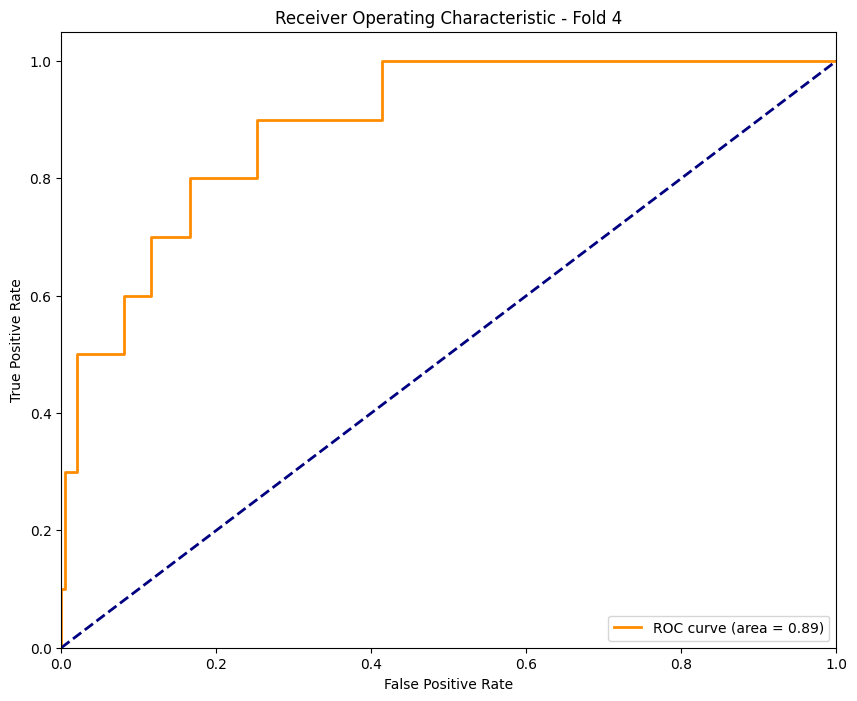

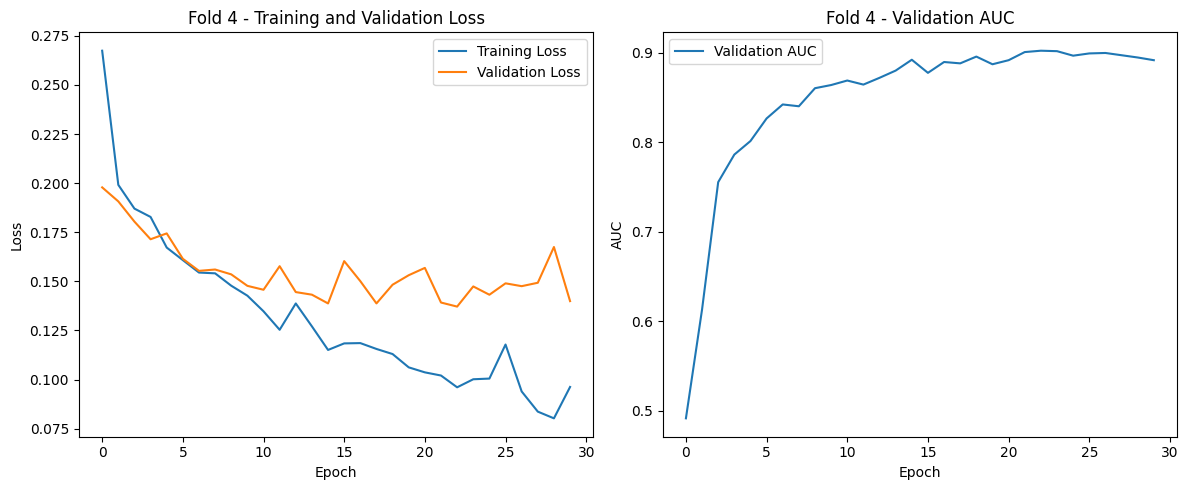


Training Fold 5
Training set: 832 images
Validation set: 208 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.2628, Val Loss: 0.2141, Val AUC: 0.6233
New best model with AUC: 0.6233


Epoch 2/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1940, Val Loss: 0.2042, Val AUC: 0.7751
New best model with AUC: 0.7751


Epoch 3/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1832, Val Loss: 0.1942, Val AUC: 0.8393
New best model with AUC: 0.8393


Epoch 4/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1763, Val Loss: 0.1837, Val AUC: 0.8686
New best model with AUC: 0.8686


Epoch 5/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1668, Val Loss: 0.1781, Val AUC: 0.8784
New best model with AUC: 0.8784


Epoch 6/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1665, Val Loss: 0.1820, Val AUC: 0.8844
New best model with AUC: 0.8844


Epoch 7/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1516, Val Loss: 0.1642, Val AUC: 0.8907
New best model with AUC: 0.8907


Epoch 8/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1525, Val Loss: 0.1611, Val AUC: 0.8907


Epoch 9/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1437, Val Loss: 0.1556, Val AUC: 0.9005
New best model with AUC: 0.9005


Epoch 10/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1374, Val Loss: 0.1541, Val AUC: 0.8997


Epoch 11/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1308, Val Loss: 0.1624, Val AUC: 0.8997


Epoch 12/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1280, Val Loss: 0.1460, Val AUC: 0.9069
New best model with AUC: 0.9069


Epoch 13/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1196, Val Loss: 0.1598, Val AUC: 0.9052


Epoch 14/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1330, Val Loss: 0.1471, Val AUC: 0.9014


Epoch 15/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1235, Val Loss: 0.1555, Val AUC: 0.9116
New best model with AUC: 0.9116


Epoch 16/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1187, Val Loss: 0.1513, Val AUC: 0.9124
New best model with AUC: 0.9124


Epoch 17/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1276, Val Loss: 0.1603, Val AUC: 0.9154
New best model with AUC: 0.9154


Epoch 18/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1127, Val Loss: 0.1516, Val AUC: 0.9133


Epoch 19/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1097, Val Loss: 0.1535, Val AUC: 0.9069


Epoch 20/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1077, Val Loss: 0.1430, Val AUC: 0.9120


Epoch 21/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1070, Val Loss: 0.1354, Val AUC: 0.9201
New best model with AUC: 0.9201


Epoch 22/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1060, Val Loss: 0.1404, Val AUC: 0.9145


Epoch 23/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1086, Val Loss: 0.1431, Val AUC: 0.9154


Epoch 24/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1113, Val Loss: 0.1416, Val AUC: 0.9171


Epoch 25/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0924, Val Loss: 0.1645, Val AUC: 0.9103


Epoch 26/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0949, Val Loss: 0.1319, Val AUC: 0.9192


Epoch 27/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1015, Val Loss: 0.1346, Val AUC: 0.9192


Epoch 28/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.1007, Val Loss: 0.1311, Val AUC: 0.9230
New best model with AUC: 0.9230


Epoch 29/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0935, Val Loss: 0.1355, Val AUC: 0.9167


Epoch 30/30 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/30 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0950, Val Loss: 0.1315, Val AUC: 0.9235
New best model with AUC: 0.9235
Saved model for fold 5 to /content/drive/MyDrive/fold_models/model_fold5.pt


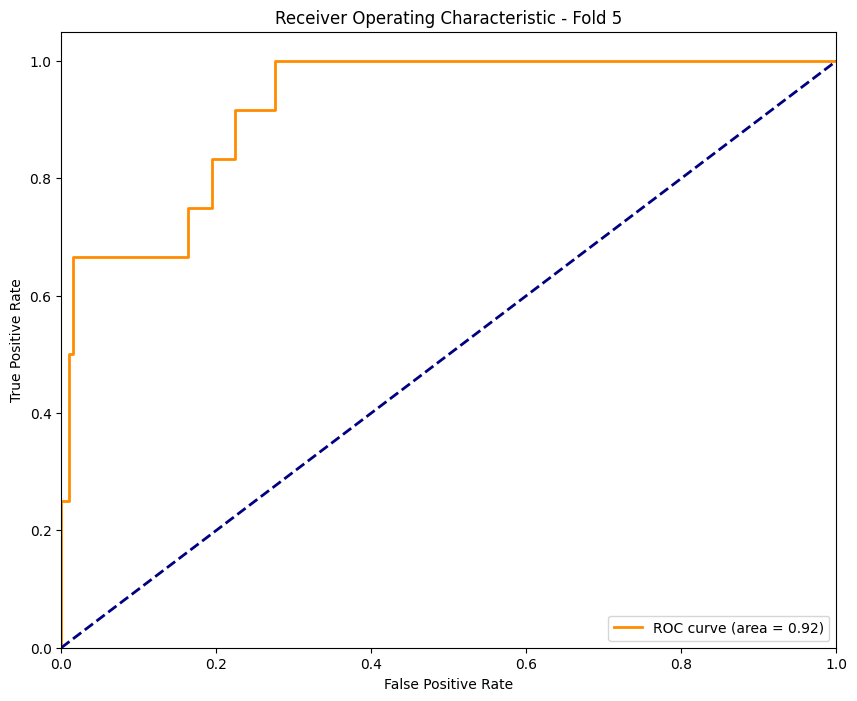

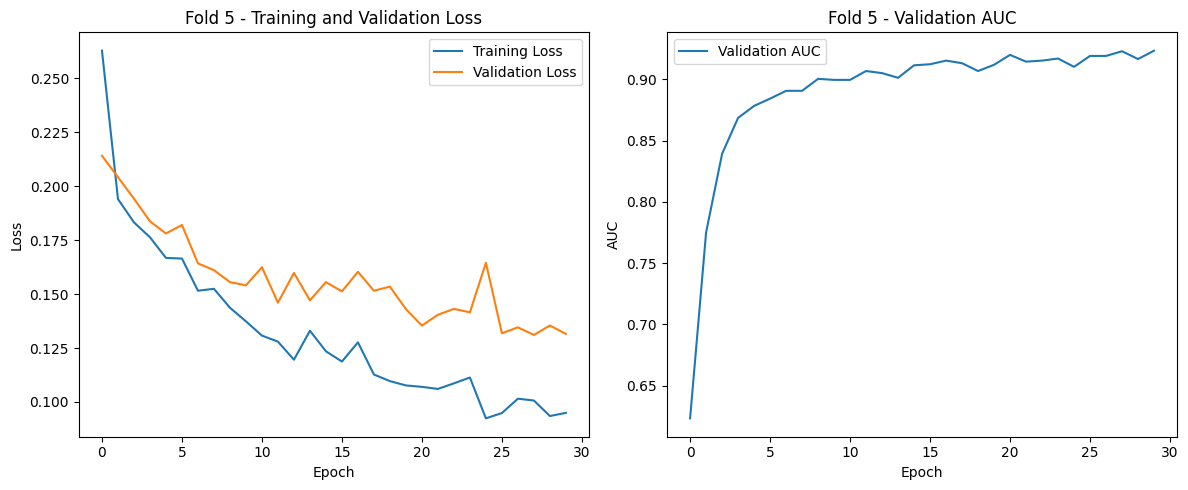

In [ ]:
for train_idx, val_idx in kf.split(X_combined):
    print(f"\nTraining Fold {fold_no}")

    X_train, X_val = X_combined[train_idx], X_combined[val_idx]
    y_train, y_val = y_combined[train_idx], y_combined[val_idx]

    print(f"Training set: {X_train.shape[0]} images")
    print(f"Validation set: {X_val.shape[0]} images")

    train_dataset = GlaucomaDataset(
        images=X_train,
        labels=y_train,
        transform=transform
    )

    val_dataset = GlaucomaDataset(
        images=X_val,
        labels=y_val,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = GlaucomaResNet(pretrained=True)
    model = model.to(device)

    for param in model.resnet.parameters():
        param.requires_grad = False


    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model, train_losses, val_losses, val_aucs = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=30
    )

    fold_model_path = os.path.join(fold_models_dir, f'model_fold{fold_no}.pt')
    torch.save(model.state_dict(), fold_model_path)
    print(f"Saved model for fold {fold_no} to {fold_model_path}")
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(labels.numpy())

    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_true = np.array(val_true)

    #calculate metrics
    accuracy = accuracy_score(val_true, val_preds_binary)
    cm = confusion_matrix(val_true, val_preds_binary)
    report = classification_report(val_true, val_preds_binary, output_dict=True)

    #ROC curve ploit
    fpr, tpr, _ = roc_curve(val_true, val_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - Fold {fold_no}')
    plt.legend(loc="lower right")
    plt.savefig(f'/content/drive/MyDrive/roc_curve_fold{fold_no}.png')
    plt.show()

    #fold results saved
    fold_results.append({
        'fold': fold_no,
        'val_accuracy': accuracy,
        'val_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': report
    })

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold_no} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='Validation AUC')
    plt.title(f'Fold {fold_no} - Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/training_curves_fold{fold_no}.png')
    plt.show()

    fold_no += 1


Cross-Validation Results:
Average Validation Accuracy: 0.9548
Average Validation AUC: 0.9197


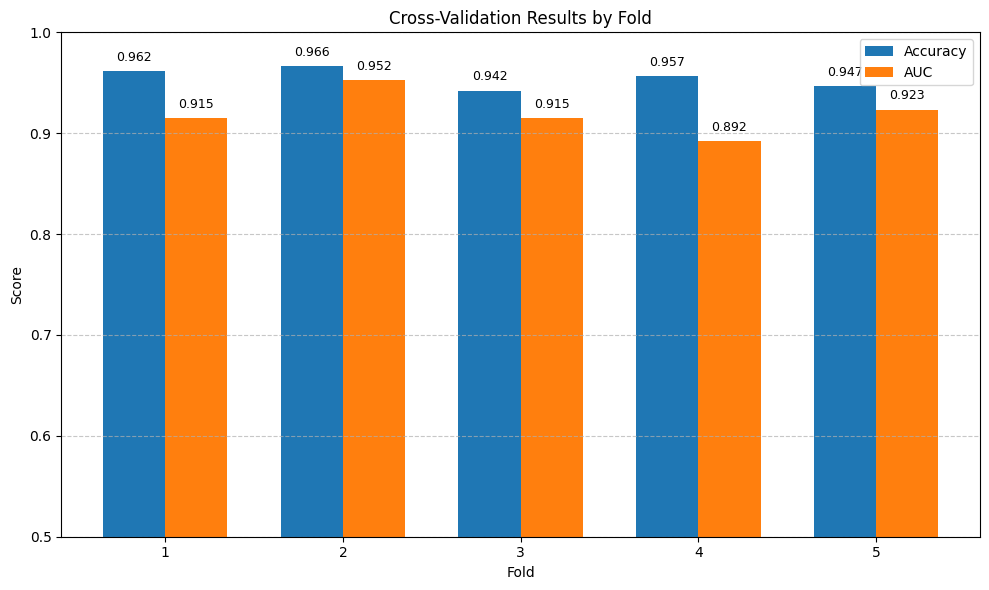

In [ ]:
#average metrics across folds
avg_val_accuracy = np.mean([fold['val_accuracy'] for fold in fold_results])
avg_val_auc = np.mean([fold['val_auc'] for fold in fold_results])

print("\nCross-Validation Results:")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Validation AUC: {avg_val_auc:.4f}")

fold_nums = [fold['fold'] for fold in fold_results]
accuracies = [fold['val_accuracy'] for fold in fold_results]
aucs = [fold['val_auc'] for fold in fold_results]

plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(fold_nums))

plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, aucs, width, label='AUC')

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-Validation Results by Fold')
plt.xticks(x, fold_nums)
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(accuracies):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

for i, v in enumerate(aucs):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cross_validation_results.png')
plt.show()

In [ ]:
print("\nTraining final model on all data...")

full_dataset = GlaucomaDataset(
    images=X_combined,
    labels=y_combined,
    transform=transform
)

full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

final_model = GlaucomaResNet(pretrained=True)
final_model = final_model.to(device)

for param in final_model.resnet.parameters():
    param.requires_grad = False


criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=1e-4)


print("Phase 1: Training with frozen ResNet layers")
final_model, train_losses1, _, _ = train_model(
    final_model,
    full_loader,
    full_loader,  
    criterion,
    optimizer,
    num_epochs=15
)


torch.save(final_model.state_dict(), '/content/drive/MyDrive/glaucoma_model_phase1.pt')
print(f"Phase 1 model saved to /content/drive/MyDrive/glaucoma_model_phase1.pt")


Training final model on all data...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Phase 1: Training with frozen ResNet layers


Epoch 1/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.2619, Val Loss: 0.1943, Val AUC: 0.6219
New best model with AUC: 0.6219


Epoch 2/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.1932, Val Loss: 0.1795, Val AUC: 0.8035
New best model with AUC: 0.8035


Epoch 3/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1829, Val Loss: 0.1718, Val AUC: 0.8579
New best model with AUC: 0.8579


Epoch 4/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.1718, Val Loss: 0.1570, Val AUC: 0.8935
New best model with AUC: 0.8935


Epoch 5/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1589, Val Loss: 0.1484, Val AUC: 0.9135
New best model with AUC: 0.9135


Epoch 6/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.1527, Val Loss: 0.1387, Val AUC: 0.9235
New best model with AUC: 0.9235


Epoch 7/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.1475, Val Loss: 0.1326, Val AUC: 0.9328
New best model with AUC: 0.9328


Epoch 8/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.1453, Val Loss: 0.1356, Val AUC: 0.9430
New best model with AUC: 0.9430


Epoch 9/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.1447, Val Loss: 0.1306, Val AUC: 0.9447
New best model with AUC: 0.9447


Epoch 10/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.1424, Val Loss: 0.1222, Val AUC: 0.9505
New best model with AUC: 0.9505


Epoch 11/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.1339, Val Loss: 0.1124, Val AUC: 0.9605
New best model with AUC: 0.9605


Epoch 12/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.1445, Val Loss: 0.1144, Val AUC: 0.9619
New best model with AUC: 0.9619


Epoch 13/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.1278, Val Loss: 0.1089, Val AUC: 0.9668
New best model with AUC: 0.9668


Epoch 14/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.1202, Val Loss: 0.1026, Val AUC: 0.9678
New best model with AUC: 0.9678


Epoch 15/15 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15/15 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.1251, Val Loss: 0.0996, Val AUC: 0.9719
New best model with AUC: 0.9719
Phase 1 model saved to /content/drive/MyDrive/glaucoma_model_phase1.pt


In [ ]:
print("Phase 2: Fine-tuning ResNet layers")
layer_count = sum(1 for _ in final_model.resnet.parameters())
print(f"Total layers in ResNet: {layer_count}")

counter = 0
for param in final_model.resnet.parameters():
    if counter >= layer_count - 20:
        param.requires_grad = True
        print(f"Unfreezing layer {counter}")
    counter += 1

optimizer = optim.Adam(final_model.parameters(), lr=1e-5)

final_model, train_losses2, _, _ = train_model(
    final_model,
    full_loader,
    full_loader,  
    criterion,
    optimizer,
    num_epochs=35
)

torch.save(final_model.state_dict(), model_path)
print(f"Final model saved to {model_path}")

Phase 2: Fine-tuning ResNet layers
Total layers in ResNet: 159
Unfreezing layer 139
Unfreezing layer 140
Unfreezing layer 141
Unfreezing layer 142
Unfreezing layer 143
Unfreezing layer 144
Unfreezing layer 145
Unfreezing layer 146
Unfreezing layer 147
Unfreezing layer 148
Unfreezing layer 149
Unfreezing layer 150
Unfreezing layer 151
Unfreezing layer 152
Unfreezing layer 153
Unfreezing layer 154
Unfreezing layer 155
Unfreezing layer 156
Unfreezing layer 157
Unfreezing layer 158


Epoch 1/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/35 - Train Loss: 0.1074, Val Loss: 0.0706, Val AUC: 0.9942
New best model with AUC: 0.9942


Epoch 2/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/35 - Train Loss: 0.0777, Val Loss: 0.0464, Val AUC: 0.9995
New best model with AUC: 0.9995


Epoch 3/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/35 - Train Loss: 0.0573, Val Loss: 0.0338, Val AUC: 1.0000
New best model with AUC: 1.0000


Epoch 4/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4/35 - Train Loss: 0.0404, Val Loss: 0.0264, Val AUC: 1.0000
New best model with AUC: 1.0000


Epoch 5/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5/35 - Train Loss: 0.0346, Val Loss: 0.0220, Val AUC: 1.0000


Epoch 6/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6/35 - Train Loss: 0.0319, Val Loss: 0.0204, Val AUC: 1.0000


Epoch 7/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7/35 - Train Loss: 0.0233, Val Loss: 0.0167, Val AUC: 1.0000


Epoch 8/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8/35 - Train Loss: 0.0213, Val Loss: 0.0147, Val AUC: 1.0000


Epoch 9/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9/35 - Train Loss: 0.0181, Val Loss: 0.0121, Val AUC: 1.0000


Epoch 10/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/35 - Train Loss: 0.0155, Val Loss: 0.0102, Val AUC: 1.0000


Epoch 11/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11/35 - Train Loss: 0.0136, Val Loss: 0.0079, Val AUC: 1.0000


Epoch 12/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12/35 - Train Loss: 0.0122, Val Loss: 0.0061, Val AUC: 1.0000


Epoch 13/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13/35 - Train Loss: 0.0086, Val Loss: 0.0047, Val AUC: 1.0000


Epoch 14/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14/35 - Train Loss: 0.0082, Val Loss: 0.0039, Val AUC: 1.0000


Epoch 15/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15/35 - Train Loss: 0.0068, Val Loss: 0.0030, Val AUC: 1.0000


Epoch 16/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16/35 - Train Loss: 0.0056, Val Loss: 0.0023, Val AUC: 1.0000


Epoch 17/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 17/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 17/35 - Train Loss: 0.0049, Val Loss: 0.0019, Val AUC: 1.0000


Epoch 18/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18/35 - Train Loss: 0.0047, Val Loss: 0.0013, Val AUC: 1.0000


Epoch 19/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19/35 - Train Loss: 0.0062, Val Loss: 0.0011, Val AUC: 1.0000


Epoch 20/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 20/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 20/35 - Train Loss: 0.0052, Val Loss: 0.0012, Val AUC: 1.0000


Epoch 21/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 21/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 21/35 - Train Loss: 0.0068, Val Loss: 0.0010, Val AUC: 1.0000


Epoch 22/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 22/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 22/35 - Train Loss: 0.0054, Val Loss: 0.0008, Val AUC: 1.0000


Epoch 23/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 23/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 23/35 - Train Loss: 0.0088, Val Loss: 0.0009, Val AUC: 1.0000


Epoch 24/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 24/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 24/35 - Train Loss: 0.0082, Val Loss: 0.0008, Val AUC: 1.0000


Epoch 25/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 25/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 25/35 - Train Loss: 0.0065, Val Loss: 0.0008, Val AUC: 1.0000


Epoch 26/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 26/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 26/35 - Train Loss: 0.0037, Val Loss: 0.0006, Val AUC: 1.0000


Epoch 27/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 27/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 27/35 - Train Loss: 0.0046, Val Loss: 0.0008, Val AUC: 1.0000


Epoch 28/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 28/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 28/35 - Train Loss: 0.0042, Val Loss: 0.0005, Val AUC: 1.0000


Epoch 29/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 29/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 29/35 - Train Loss: 0.0020, Val Loss: 0.0004, Val AUC: 1.0000


Epoch 30/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 30/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 30/35 - Train Loss: 0.0024, Val Loss: 0.0004, Val AUC: 1.0000


Epoch 31/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 31/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 31/35 - Train Loss: 0.0018, Val Loss: 0.0003, Val AUC: 1.0000


Epoch 32/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 32/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 32/35 - Train Loss: 0.0015, Val Loss: 0.0002, Val AUC: 1.0000


Epoch 33/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 33/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 33/35 - Train Loss: 0.0018, Val Loss: 0.0002, Val AUC: 1.0000


Epoch 34/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 34/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 34/35 - Train Loss: 0.0016, Val Loss: 0.0002, Val AUC: 1.0000


Epoch 35/35 Training:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 35/35 Validation:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 35/35 - Train Loss: 0.0022, Val Loss: 0.0002, Val AUC: 1.0000
Final model saved to /content/drive/MyDrive/glaucoma_model.pt


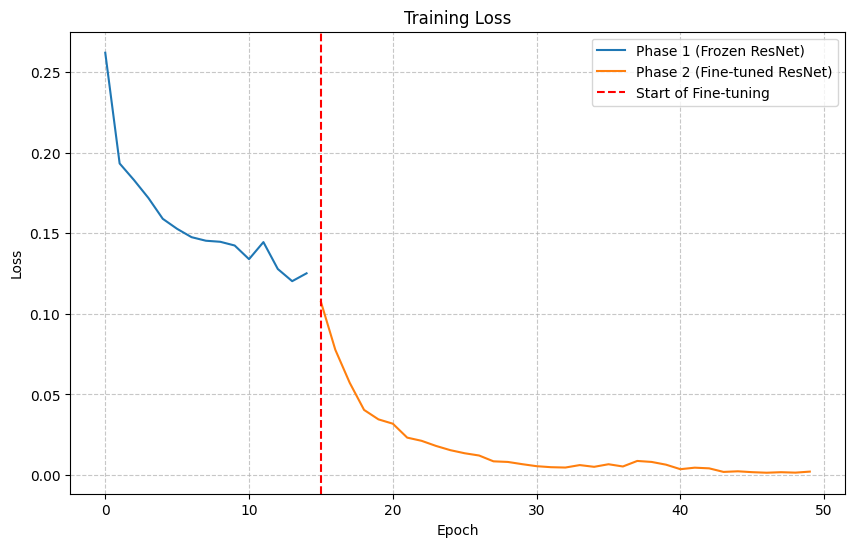

Evaluating final model:   0%|          | 0/65 [00:00<?, ?it/s]

Final Model Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       988
    Glaucoma       1.00      1.00      1.00        52

    accuracy                           1.00      1040
   macro avg       1.00      1.00      1.00      1040
weighted avg       1.00      1.00      1.00      1040



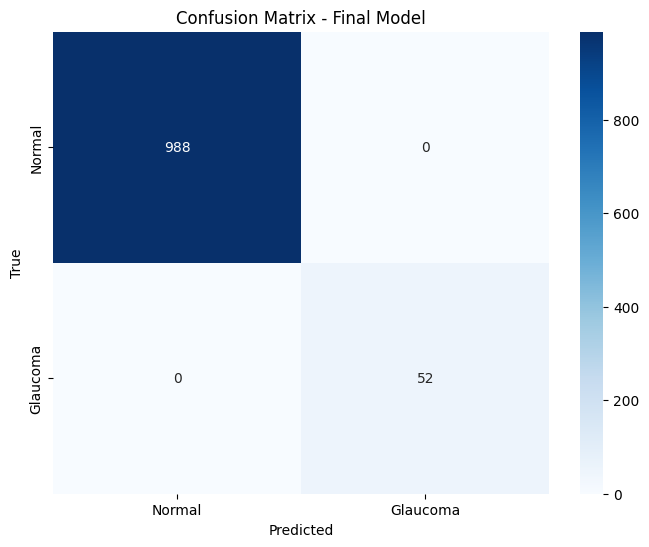

training complete


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses1, label='Phase 1 (Frozen ResNet)')
plt.plot(range(len(train_losses1), len(train_losses1) + len(train_losses2)),
         train_losses2, label='Phase 2 (Fine-tuned ResNet)')
plt.axvline(x=len(train_losses1), color='red', linestyle='--',
            label='Start of Fine-tuning')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('/content/drive/MyDrive/final_training_curve.png')
plt.show()

final_model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in tqdm(full_loader, desc="Evaluating final model"):
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(labels.numpy())


all_preds_binary = (np.array(all_preds) > 0.5).astype(int)
all_true = np.array(all_true)

final_accuracy = accuracy_score(all_true, all_preds_binary)
final_cm = confusion_matrix(all_true, all_preds_binary)
final_report = classification_report(all_true, all_preds_binary,
                                    target_names=['Normal', 'Glaucoma'])

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(final_report)


plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Glaucoma'],
            yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Final Model')
plt.savefig('/content/drive/MyDrive/final_confusion_matrix.png')
plt.show()

print("training complete")